In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.datasets import load_iris, make_moons
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.base import clone
import pydotplus
from IPython.display import Image
from io import StringIO
from scipy import stats
%matplotlib inline


In [2]:
inputs = [
        ({'level':'Senior','lang':'Java','tweets':'no','phd':'no'},   False),
        ({'level':'Senior','lang':'Java','tweets':'no','phd':'yes'},  False),
        ({'level':'Mid','lang':'Python','tweets':'no','phd':'no'},     True),
        ({'level':'Junior','lang':'Python','tweets':'no','phd':'no'},  True),
        ({'level':'Junior','lang':'R','tweets':'yes','phd':'no'},      True),
        ({'level':'Junior','lang':'R','tweets':'yes','phd':'yes'},    False),
        ({'level':'Mid','lang':'R','tweets':'yes','phd':'yes'},        True),
        ({'level':'Senior','lang':'Python','tweets':'no','phd':'no'}, False),
        ({'level':'Senior','lang':'R','tweets':'yes','phd':'no'},      True),
        ({'level':'Junior','lang':'Python','tweets':'yes','phd':'no'}, True),
        ({'level':'Senior','lang':'Python','tweets':'yes','phd':'yes'},True),
        ({'level':'Mid','lang':'Python','tweets':'no','phd':'yes'},    True),
        ({'level':'Mid','lang':'Java','tweets':'yes','phd':'no'},      True),
        ({'level':'Junior','lang':'Python','tweets':'no','phd':'yes'},False)
    ]

In [3]:
def entropy(prob):
    if sum(prob) != 1:
        raise ValueError('Probabilites must add to exactly one')
    return sum(-p * math.log2(p) for p in prob if p)

In [4]:
def class_probability(labels):
    total = len(labels)
    count = Counter(labels)
    return [c/total for c in count.values()]

In [5]:
def data_entropy(subset):
    labels = [s for _, s in subset]
    return entropy(class_probability(labels))

In [6]:
def partition_entropy(subsets):
    total_count = sum(len(s) for s in subsets)
    return sum([data_entropy(s) * len(s) / total_count for s in subsets])

In [7]:
def partition_by(data, attribute=None):
    result = defaultdict(list)
    key = None
    for i in data:
        if attribute:
            key = i[0][attribute]
        result[key].append(i)
    return result

### IG without partition

In [8]:
print(partition_entropy(partition_by(inputs).values()))

0.9402859586706311


### Check first partition criteria

In [9]:
keys = {i for i in inputs[0][0].keys()}
for key in keys:
    print(key,partition_entropy(partition_by(inputs, key).values()))

level 0.6935361388961919
phd 0.8921589282623617
lang 0.8601317128547441
tweets 0.7884504573082896


### We have to split for level

In [10]:
keys.remove('level')
input_senior = partition_by(inputs, 'level')['Senior']
input_mid = partition_by(inputs, 'level')['Mid']
input_junior = partition_by(inputs, 'level')['Junior']

### Second level partion

In [11]:
for key in keys:
    print(key,partition_entropy(partition_by(input_senior, key).values()))

phd 0.9509775004326938
lang 0.4
tweets 0.0


In [12]:
for key in keys:
    print(key,partition_entropy(partition_by(input_mid, key).values()))

phd 0.0
lang 0.0
tweets 0.0


In [13]:
for key in keys:
    print(key,partition_entropy(partition_by(input_junior, key).values()))

phd 0.0
lang 0.9509775004326938
tweets 0.9509775004326938


# Using Sklearn

In [14]:
def draw_tree(tree, feature_names):
    dot_data = export_graphviz(tree, out_file=None, 
                               feature_names=feature_names,
                               class_names=iris.target_names,
                               rounded=True,
                               filled=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    return graph.create_png()

In [15]:
iris = load_iris()
print("Using features {}".format(iris.feature_names[2:]))

Using features ['petal length (cm)', 'petal width (cm)']


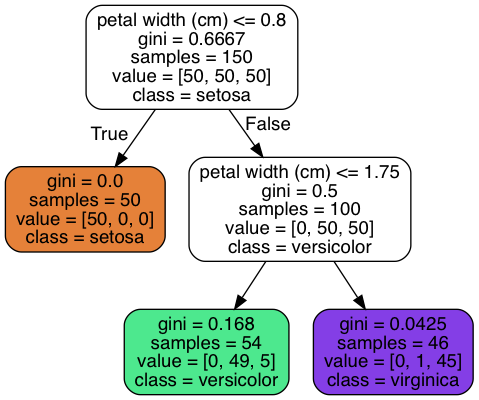

In [16]:
X = iris.data[:,2:]
y = iris.target
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X,y)
Image(draw_tree(tree_clf, iris.feature_names[2:]))

In [17]:
tree_clf.predict(np.array([5,1.5]).reshape(1,-1))
print(iris.target_names[tree_clf.predict(np.array([5,1.5]).reshape(1,-1))[0]])
print(tree_clf.predict_proba(np.array([5,1.5]).reshape(1,-1)))
print(tree_clf.predict_proba(np.array([2.46,1.75]).reshape(1,-1)))

versicolor
[[ 0.          0.90740741  0.09259259]]
[[ 0.          0.90740741  0.09259259]]


### Gini is 20% faster than IG (entropy)

In [ ]:
%timeit [math.log(i) for i in range(1,100000000)]

In [ ]:
%timeit [i*math.log(i) for i in range(1,100000000)]

In [ ]:
((29.1 - 24.1)*100)/24.1

## Regression Trees

### Quadratic training set + noise

In [18]:
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10
stats.describe(X.reshape(1,-1)[0])

DescribeResult(nobs=200, minmax=(0.0055221171236023991, 0.98688693660051729), mean=0.48400623326661618, variance=0.086960956180070284, skewness=0.08565816593777022, kurtosis=-1.2875184238816466)

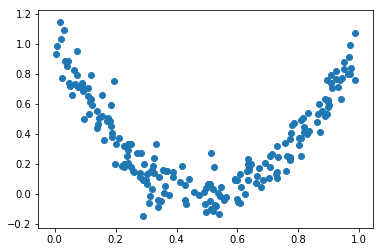

In [19]:
plt.scatter(X,y)

In [20]:
tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

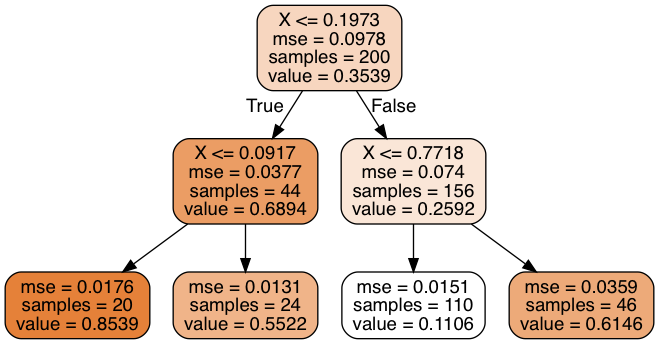

In [21]:
Image(draw_tree(tree_reg,['X']))

## Make Moon Fitting

In [22]:
X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [23]:
tree_cl = DecisionTreeClassifier()
tree_cl.fit(X_train,y_train)
y_pred = tree_cl.predict(X_test)
accuracy_score(y_pred=y_pred, y_true=y_test)

0.81299999999999994

In [24]:
hyperparameters = {'criterion':['gini','entropy'],
                   'max_leaf_nodes':range(2,20), 
                   'min_samples_split': range(2,5)
                  }
grid_search_cv = GridSearchCV(DecisionTreeClassifier(), hyperparameters, verbose=1)
grid_search_cv.fit(X_train, y_train)
grid_search_cv.best_estimator_


Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:    2.9s finished


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=17, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Train Accuracy

In [25]:
tree_cl = clone(grid_search_cv.best_estimator_)
tree_cl.fit(X_test,y_test)
y_pred = tree_cl.predict(X_test)
accuracy_score(y_pred=y_test, y_true=y_test)

1.0

### Test Accuracy

In [26]:
tree_cl = clone(grid_search_cv.best_estimator_)
tree_cl.fit(X_train,y_train)
y_pred = tree_cl.predict(X_test)
accuracy_score(y_pred=y_pred, y_true=y_test)

0.86950000000000005

## Grow a forest

In [27]:
def train_tree(X_train,y_train):
    tree_cl = clone(grid_search_cv.best_estimator_)
    tree_cl.fit(X_train,y_train)
    return tree_cl

In [30]:
ss = ShuffleSplit(n_splits=1000,  train_size=100, test_size=None, random_state=42)

forest = []
acc = []
for train_index, _ in ss.split(X_train):
    X_sample_train = X_train[train_index]
    y_sample_train = y_train[train_index]
    forest.append(train_tree(X_sample_train,y_sample_train))

for f in forest:
    acc.append(accuracy_score(y_pred=f.predict(X_test),y_true=y_test))
print("Mean Accuracy over testing dataset: {:.5f}".format(np.mean(acc)))

predictions = []
for f in forest:
    predictions.append(f.predict(X_test))
predictions = np.array(predictions)

Mean Accuracy over testing dataset: 0.80527


In [31]:
predictions.shape
stats.mode(predictions)[0]
accuracy_score(y_pred=stats.mode(predictions)[0].reshape(2000,1), y_true=y_test)

0.872